# Ratio Put-Spread Strategy

In [1]:
import os
from pathlib import Path
from dotenv import load_dotenv
load_dotenv()
tick_path = os.getenv("TICK_PATH", "").split(os.pathsep)[0]

p = Path(tick_path)
if p.is_dir():  # make sure it exists
    available_ticks =[f.name.replace('.parquet', '') for f in p.iterdir() if f.is_file()]

#### __Defining the universe__
The entire execution pipeline is handled via the DataManager class, so we just add methods to the pipline which get executed once the pipeline is populated. Due to the volume of data to be processed, options chains are pulled in in parallel, processed and then deleted from memory. Necessary data are retained in the model and used for later inference. 

In [ ]:
import options_wizard as ow
import pandas as pd
tick = "^IXIC"
universe = ow.Universe()
universe.top_constituents(10)
universe.check_ticks()
data_manager = ow.DataManager(universe, load_lazy=True)
len(data_manager.universe.ticks)

C:\Users\cameronA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\exchange_calendars\exchange_calendar.py:2346: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  align: pd.Timedelta | str = pd.Timedelta(1, "T"),
C:\Users\cameronA\Desktop\options_wizard\src\universe.py:48: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  index_df["date"] = pd.to_datetime(index_df["date"])
C:\Users\cameronA\Desktop\options_wizard\src\universe.py:49: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  mktcap_df["date"] = pd.to_datetime(mktcap_df["date"])


11

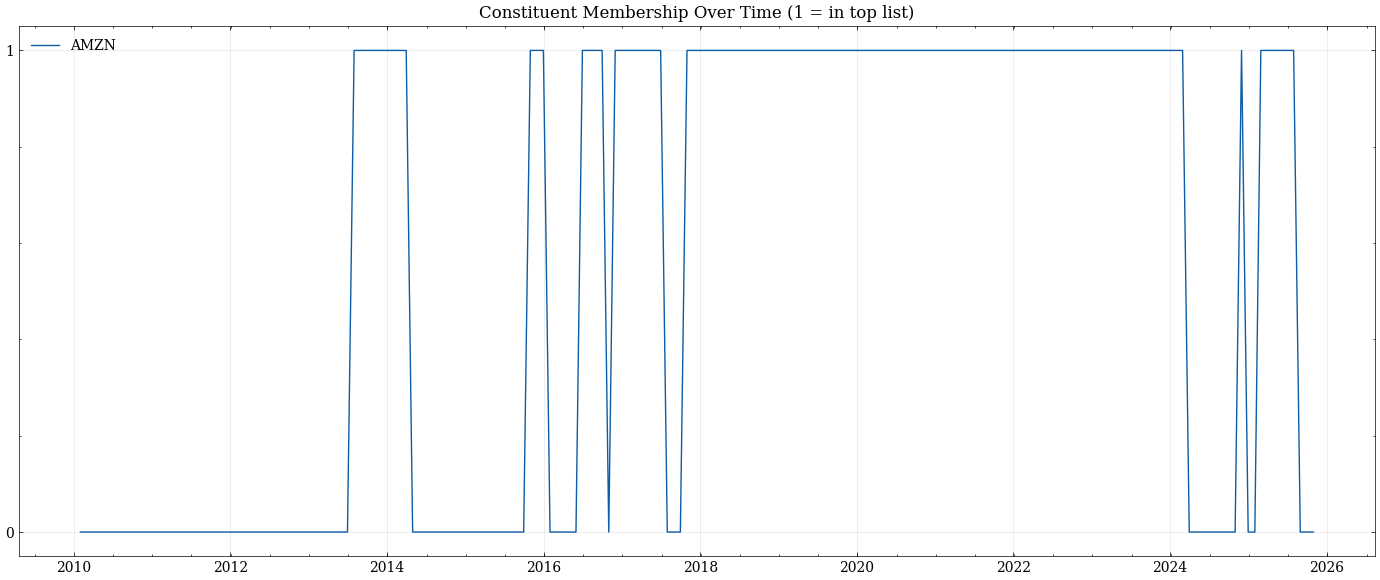

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# your Series
s = data_manager.universe.top_per_date  # index=dates, values=list of tickers

# get full unique set of tickers across all dates
all_tickers = sorted({t for lst in s for t in lst})

# build a DataFrame: rows=dates, cols=tickers, values=1/0
membership = pd.DataFrame(
    0, index=s.index, columns=all_tickers
)

for date, tickers in s.items():
    membership.loc[date, tickers] = 1

# Plot
plt.figure(figsize=(14, 6))
for ticker in ['AMZN']:
    plt.plot(membership.index, membership[ticker], label=ticker)

plt.title("Constituent Membership Over Time (1 = in top list)")
plt.yticks([0, 1])
plt.grid(True, alpha=0.3)
plt.legend(loc="upper left", ncol=2)
plt.tight_layout()
plt.show()


#### __Transforming the Data__
Data transformations are those which will define the dataset for a given stock, that can be then used to infer features, returns and execute strategies. These methods can filter out contracts, changing the size of the options chain dataframe. These, along with the rest of the dataset are deleted once the tick's pipeline has been executed.

In [3]:
ow.Transformer(data_manager)('scale_by_splits', upper_date = pd.Timestamp('2022-01-01'))
ow.Transformer(data_manager)('set_index', index_cols=['strike', 'trade_date', 'expiry_date', 'call_put'], dedupe=True)
ow.Transformer(data_manager)('get_underlying')
ow.Transformer(data_manager)('flag_chain_gaps', drop_on_gap = True)
ow.Transformer(data_manager)('to_datetime', columns=['trade_date', 'expiry_date'])
ow.Transformer(data_manager)('flag_stale_options', volume_threshold=0)
ow.Transformer(data_manager)('drop_contract', drop = 'c')
ow.Transformer(data_manager)('pull_earnings_dates')
ow.Transformer(data_manager)('filter_ttms', min_ttm=3)
ow.Transformer(data_manager)('compute_rv', period=30)
ow.Transformer(data_manager)('train_test_split', upper_date=pd.Timestamp('2022-01-01').tz_localize('America/New_York'), drop_out_of_sample=True)
ow.Transformer(data_manager)('implied_volatility')
ow.Transformer(data_manager)('mid_price')


#### __Defining the Trade Strategy__
This defines the trade strategy for the model. It is important that the returns of the strategy are fit to the same row as the features of the strategy. Ie if you have an entry signal, the returns of the subsequent trade should be in the same column as the entry signal.

In [4]:
ow.Strategy(data_manager)('ratio_spread', lower_ttm=91, upper_ttm=121, delta_atm=0.3, delta_otm=0.1, otm_ratio=2, hold_period=30, call_put='p')
ow.Backtest(data_manager)('multi_day_entry', hold_period=30, entry_cost_size='short', entry_notional='underlying', initial_capital=1_000_000.0, capital_per_trade=12/(256), all_returns=True)
ow.Backtest(data_manager)("multi_stock", initial_capital=1_000_000,entry_notional = True, fixed_notional_exposure = 1_000_000*12/252,  allocation_basis="short")

#### __Model prediction and Pipeline Execution__
The model pipeline execution is paralelised accross available cores, this is defaulted to at 8 due to memory issues.

In [5]:
data_manager.execute_pipeline(retain_data=False, save_data=False, n_workers=4)

Deferring method multi_stock for all stocksRunning post-processing method multi_stock for ticks ['AMZN', 'MSFT', 'CSCO', 'META', 'INTC', 'GOOGL', 'GOOG', 'NVDA', 'VOD', 'AAPL', 'ORCL']


#### __Result Visualisation__ 

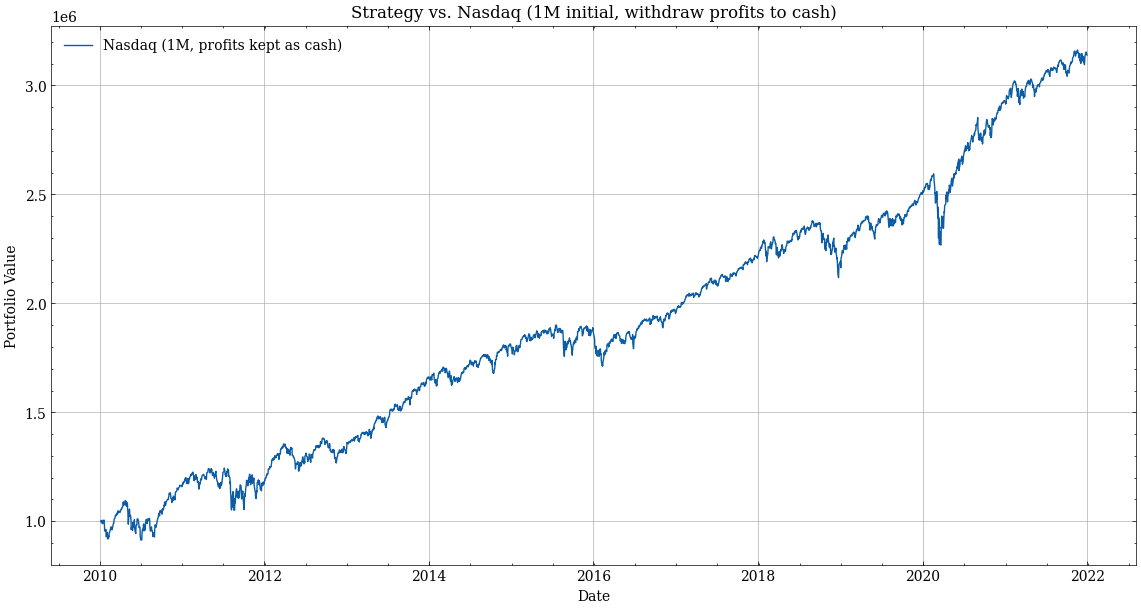

In [6]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotx
import scienceplots
import matplotlib as mpl

plt.style.use('science')
mpl.rcParams['text.usetex'] = False

# ----------------------------
# Load Nasdaq and scale to 1M initial
# ----------------------------
nasdaq = yf.Ticker(tick).history(
    start="2010-01-01", 
    end="2022-01-01", 
    interval="1d",
    auto_adjust=False,

)['Close']

nasdaq_scaled = nasdaq / nasdaq.iloc[0] * 1_000_000


#--------------
# Compute “withdraw profits as cash” baseline
# ----------------------------
initial_value = 1_000_000

# Value of investment if we *never reinvest profits*
# Cash accumulates whenever the new equity > previous equity
cash = 0.0
baseline = pd.Series(index=nasdaq_scaled.index, dtype='float64')
baseline.iloc[0] = initial_value

for i in range(1, len(nasdaq_scaled)):
    cash += (nasdaq_scaled.iloc[i] - nasdaq_scaled.iloc[i - 1]) / nasdaq_scaled.iloc[i - 1] * initial_value
    baseline.iloc[i] = initial_value + cash

# ----------------------------
# Plot results
# ----------------------------
plt.figure(figsize=(14, 7))
#plt.plot(strategy.index, strategy, label="Strategy Equity")
plt.plot(baseline.index, baseline, label="Nasdaq (1M, profits kept as cash)")
plt.title("Strategy vs. Nasdaq (1M initial, withdraw profits to cash)")
plt.ylabel("Portfolio Value")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()


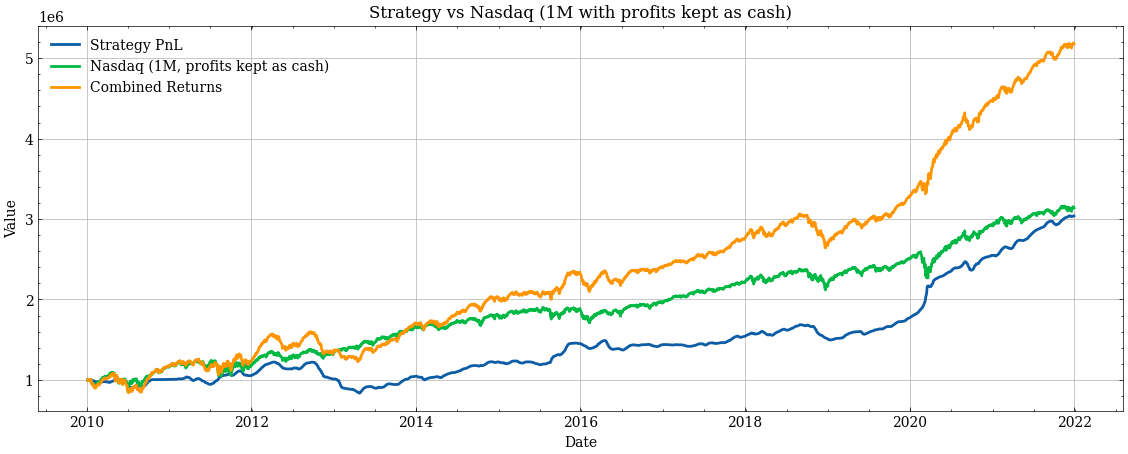

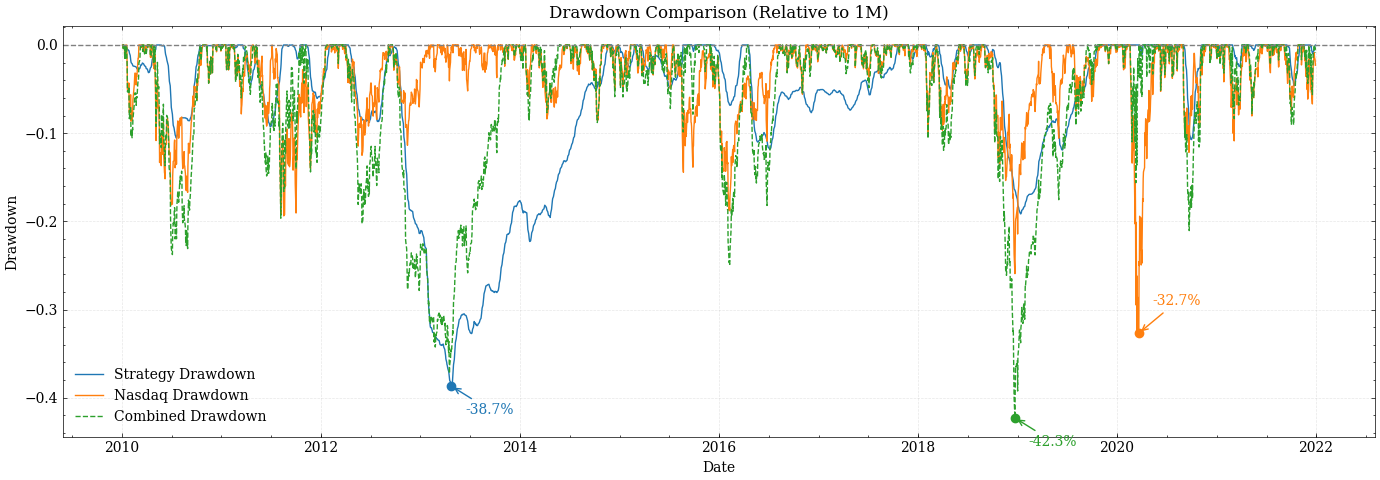

In [7]:


pos_val = data_manager.combined_outputs['multi_stock']['equity_obj'].apply(
    lambda x: sum(
        c.current_pnl
        for c in x.active_contracts
    )
)

pnl_shorts = data_manager.combined_outputs['multi_stock']['equity_obj'].apply(
    lambda x: sum(
        c.current_pnl
        for c in x.active_contracts if c.scaled_position < 0
    )
)

pnl_longs = data_manager.combined_outputs['multi_stock']['equity_obj'].apply(
    lambda x: sum(
        c.current_pnl
        for c in x.active_contracts if c.scaled_position > 0
    )
)

pos_val.index = pos_val.index.tz_localize('America/New_York')
# ---- align indices ----
aligned = pd.concat([pos_val.cumsum(), baseline], axis=1, join="outer")
#aligned = aligned[aligned.index < pd.Timestamp("2020-01-01").tz_localize('America/New_York')]
aligned.columns = ["strategy", "nasdaq"]

# ---- combined returns (strategy + nasdaq) ----
aligned["combined"] = aligned["strategy"] + aligned["nasdaq"]

# ---- plot ----
plt.figure(figsize=(14, 5))

#
# 
plt.plot(aligned.index, aligned["strategy"] + 1_000_000, label="Strategy PnL", linewidth=2)
plt.plot(aligned.index, aligned["nasdaq"], label="Nasdaq (1M, profits kept as cash)", linewidth=2)
plt.plot(aligned.index, aligned["combined"], label="Combined Returns", linewidth=2)

plt.title("Strategy vs Nasdaq (1M with profits kept as cash)")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)
plt.legend()
plt.show()



strategy_equity = aligned["strategy"] + 1_000_000
nasdaq_equity = aligned["nasdaq"]
comb_equity = aligned["combined"]

strategy_drawdown = strategy_equity.div(1_000_000).sub(strategy_equity.cummax()/1_000_000)
nasdaq_drawdown = nasdaq_equity.div(1_000_000).sub(nasdaq_equity.cummax()/1_000_000)
combined_drawdown = (aligned["strategy"] + aligned["nasdaq"]).div(1_000_000).sub((aligned["strategy"] + aligned["nasdaq"]).cummax()/1_000_000)

strategy_mdd_date = strategy_drawdown.idxmin()
nasdaq_mdd_date = nasdaq_drawdown.idxmin()
combined_mdd_date = combined_drawdown.idxmin()

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(strategy_drawdown.index, strategy_drawdown, label="Strategy Drawdown", color="tab:blue")
ax.plot(nasdaq_drawdown.index, nasdaq_drawdown, label="Nasdaq Drawdown", color="tab:orange")
ax.plot(aligned.index, combined_drawdown, label="Combined Drawdown", linestyle="--", color="tab:green")
ax.axhline(0, color="gray", linewidth=1, linestyle="--")

ax.scatter(strategy_mdd_date, strategy_drawdown.loc[strategy_mdd_date], color="tab:blue")
ax.scatter(nasdaq_mdd_date, nasdaq_drawdown.loc[nasdaq_mdd_date], color="tab:orange")
ax.scatter(combined_mdd_date,combined_drawdown.loc[combined_mdd_date], color="tab:green")

ax.annotate(
    f"{strategy_drawdown.loc[strategy_mdd_date]:.1%}",
    xy=(strategy_mdd_date, strategy_drawdown.loc[strategy_mdd_date]),
    xytext=(10, -20),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->", color="tab:blue"),
    color="tab:blue"
)
ax.annotate(
    f"{nasdaq_drawdown.loc[nasdaq_mdd_date]:.1%}",
    xy=(nasdaq_mdd_date, nasdaq_drawdown.loc[nasdaq_mdd_date]),
    xytext=(10, 20),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->", color="tab:orange"),
    color="tab:orange"
)
ax.annotate(
    f"{combined_drawdown.loc[combined_mdd_date]:.1%}",
    xy=(combined_mdd_date, combined_drawdown.loc[combined_mdd_date]),
    xytext=(10, -20),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->", color="tab:green"),
    color="tab:green"
)

ax.set_title("Drawdown Comparison (Relative to 1M)")
ax.set_xlabel("Date")
ax.set_ylabel("Drawdown")
ax.grid(True, linestyle="--", alpha=0.3)
ax.legend(frameon=False)
fig.tight_layout()


In [8]:
data_manager.combined_outputs['multi_stock']['equity_obj'][0].active_contracts[0].scaled_position

C:\Users\cameronA\AppData\Local\Temp\ipykernel_19708\4174324084.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data_manager.combined_outputs['multi_stock']['equity_obj'][0].active_contracts[0].scaled_position


-769.2899264168715

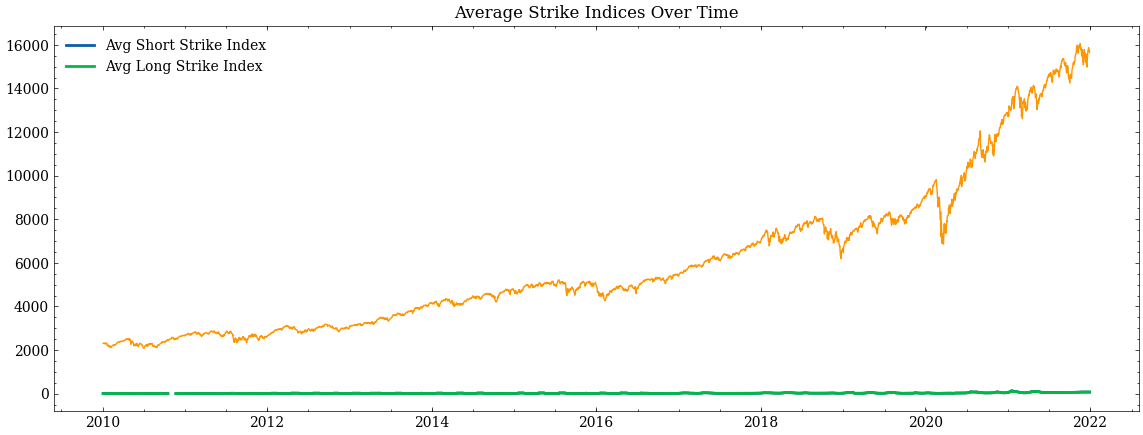

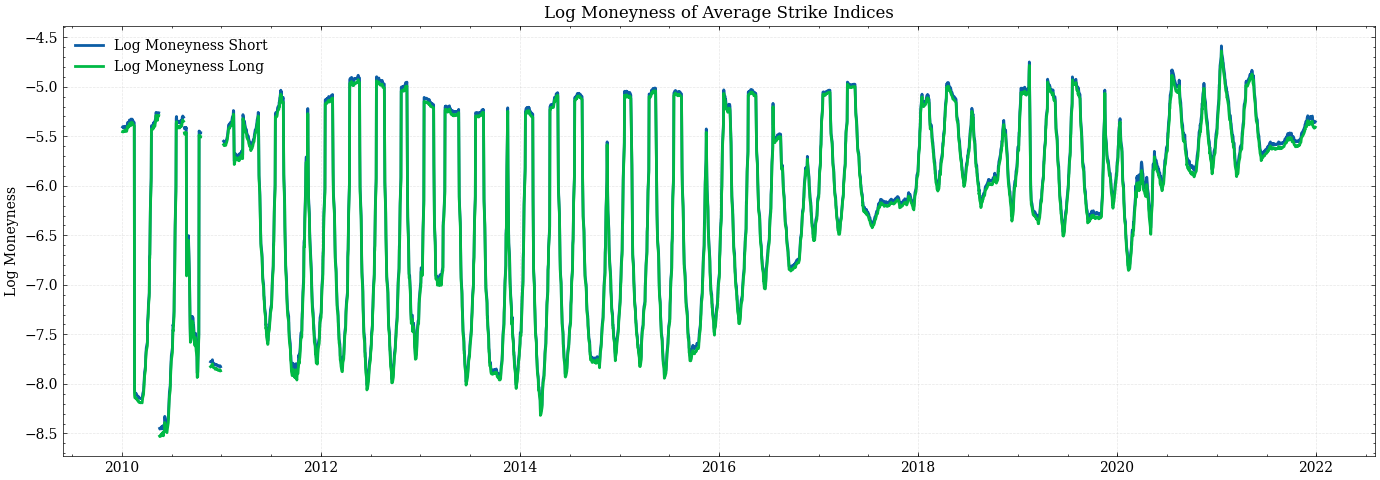

In [9]:
avg_short_strike = data_manager.combined_outputs['multi_stock']['equity_obj'].apply(
    lambda x: sum(
        c.strike_idx * np.abs(c.scaled_position)
        for c in x.active_contracts
    ) / sum(
        np.abs(c.scaled_position) for c in x.active_contracts 
    ) if sum(
        np.abs(c.scaled_position) for c in x.active_contracts 
    ) > 0 else np.nan
)

avg_long_strike = data_manager.combined_outputs['multi_stock']['equity_obj'].apply(
    lambda x: sum(
        c.strike_idx * c.scaled_position
        for c in x.active_contracts if c.scaled_position > 0
    ) / sum(
        c.scaled_position for c in x.active_contracts if c.scaled_position > 0
    ) 
    if sum(
        c.scaled_position for c in x.active_contracts if c.scaled_position > 0
    ) > 0 else np.nan
)

plt.figure(figsize=(14, 5))
plt.plot(avg_short_strike.index, avg_short_strike, label="Avg Short Strike Index", linewidth=2)
plt.plot(avg_long_strike.index, avg_long_strike, label="Avg Long Strike Index", linewidth=2)
plt.title("Average Strike Indices Over Time")
plt.legend()
plt.plot(nasdaq.index, nasdaq)

nasdaq_naive = nasdaq.copy()
if getattr(nasdaq_naive.index, "tz", None) is not None:
    nasdaq_naive.index = nasdaq_naive.index.tz_localize(None)

underlying = nasdaq_naive.reindex(avg_short_strike.index).ffill()

log_m_short = np.log(avg_short_strike / underlying)
log_m_long = np.log(avg_long_strike / underlying)

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(log_m_short.index, log_m_short, label="Log Moneyness Short", linewidth=2)
ax.plot(log_m_long.index, log_m_long, label="Log Moneyness Long", linewidth=2)
ax.set_title("Log Moneyness of Average Strike Indices")
ax.set_ylabel("Log Moneyness")
ax.legend()
ax.grid(True, linestyle="--", alpha=0.3)
fig.tight_layout()

In [10]:
period_years = (comb_equity.index[-1] - comb_equity.index[0]) / pd.Timedelta(days=365.25)
print(period_years)

print((comb_equity.iloc[-1] / comb_equity.iloc[0] - 1) / period_years)
print((nasdaq_equity.iloc[-1] / nasdaq_equity.iloc[0] - 1) / period_years)
print((strategy_equity.iloc[-1] / strategy_equity.iloc[0] - 1) / period_years)

returns_comb = np.log(comb_equity - comb_equity.shift(1) + 1_000_000) - np.log(1_000_000)
returns_nasdaq = np.log(nasdaq_equity - nasdaq_equity.shift(1) + 1_000_000) - np.log(1_000_000)
returns_strategy = np.log(strategy_equity - strategy_equity.shift(1) + 1_000_000) - np.log(1_000_000)

vol_comb = returns_comb.std() * np.sqrt(252)
vol_nasdaq = returns_nasdaq.std() * np.sqrt(252)
vol_strategy = returns_strategy.std() * np.sqrt(252)

print("Combined Vol:", vol_comb)
print("Nasdaq Vol:", vol_nasdaq)
print("Strategy Vol:", vol_strategy)

sharpe_comb = returns_comb.mean() / returns_comb.std() * np.sqrt(252)
sharpe_nasdaq = returns_nasdaq.mean() / returns_nasdaq.std() * np.sqrt(252)
sharpe_strategy = returns_strategy.mean() / returns_strategy.std() * np.sqrt(252)

print("Combined Sharpe:", sharpe_comb)
print("Nasdaq Sharpe:", sharpe_nasdaq)
print("Strategy Sharpe:", sharpe_strategy)

correlation = returns_comb.corr(returns_nasdaq)
strat_correlation = returns_strategy.corr(returns_nasdaq)
print("Correlation between Strategy and Nasdaq returns:", strat_correlation)
print("Correlation between Combined and Nasdaq returns:", correlation)

print("Strategy Skew" , returns_strategy.skew())
print("Nasdaq Skew" , returns_nasdaq.skew())
print("Combined Skew" , returns_comb.skew())


11.989048596851472
0.34856231879305594
0.17845455318244735
0.1701077656106085
Combined Vol: 0.20138068206889015
Nasdaq Vol: 0.19416458595366395
Strategy Vol: 0.04507372237199341
Combined Sharpe: 1.629795300804811
Nasdaq Sharpe: 0.8223782201401582
Strategy Sharpe: 3.7517011824548043
Correlation between Strategy and Nasdaq returns: 0.05886519871087865
Correlation between Combined and Nasdaq returns: 0.9740865409540271
Strategy Skew 1.6181521523156366
Nasdaq Skew -0.7578468668944938
Combined Skew -0.19704624961525596


In [11]:
delta = data_manager.combined_outputs['multi_stock']['equity_obj'].apply(
    lambda x: sum(
        c.scaled_position * c.delta * c.underlying_close
        for c in x.active_contracts
    ) / sum(
        c.scaled_position * c.underlying_close
        for c in x.active_contracts
    ) if sum(
        c.scaled_position * c.underlying_close
        for c in x.active_contracts
    ) != 0 else 0.0
)
theta = data_manager.combined_outputs['multi_stock']['equity_obj'].apply(
    lambda x: sum(
        c.scaled_position * c.theta
        for c in x.active_contracts
    )
)

vega = data_manager.combined_outputs['multi_stock']['equity_obj'].apply(
    lambda x: sum(
        c.scaled_position * c.vega
        for c in x.active_contracts
    )
)

def as_naive_date(ts):
    ts = pd.to_datetime(ts)
    return ts.tz_localize(None).normalize() if ts.tzinfo else ts.normalize()

entry_cost = data_manager.combined_outputs['multi_stock']['equity_obj'].apply(
    lambda x: sum(
        c.scaled_position * c.last_price
        for c in x.active_contracts
        if as_naive_date(c.entry_date) == as_naive_date(x.date)
    )
)

mean_delta = delta.mean()
mean_theta = theta.mean()
mean_vega = vega.mean()
mean_entry_cost = entry_cost.mean()

std_delta = delta.std()
std_theta = theta.std()
std_vega = vega.std()
std_entry_cost = entry_cost.std()

skew_delta = delta.skew()
skew_theta = theta.skew()
skew_vega = vega.skew()
skew_entry_cost = entry_cost.skew()

print("Mean Delta:", mean_delta, "Std Dev:", std_delta, "Skew:", skew_delta)
print("Mean Theta:", mean_theta, "Std Dev:", std_theta, "Skew:", skew_theta)
print("Mean Vega:", mean_vega, "Std Dev:", std_vega, "Skew:", skew_vega)
print("Mean Entry Cost:", mean_entry_cost, "Std Dev:", std_entry_cost, "Skew:", skew_entry_cost)

Mean Delta: 0.044132484249968594 Std Dev: 0.02636777384478552 Skew: -1.6527039962267105
Mean Theta: -879.2122261963983 Std Dev: 1112.2048667698868 Skew: -3.0377674064531957
Mean Vega: 1820.3793950336174 Std Dev: 4453.724795538429 Skew: 1.500970259835119
Mean Entry Cost: -353.7721981777156 Std Dev: 222.46702179830558 Skew: -0.17614457080863527


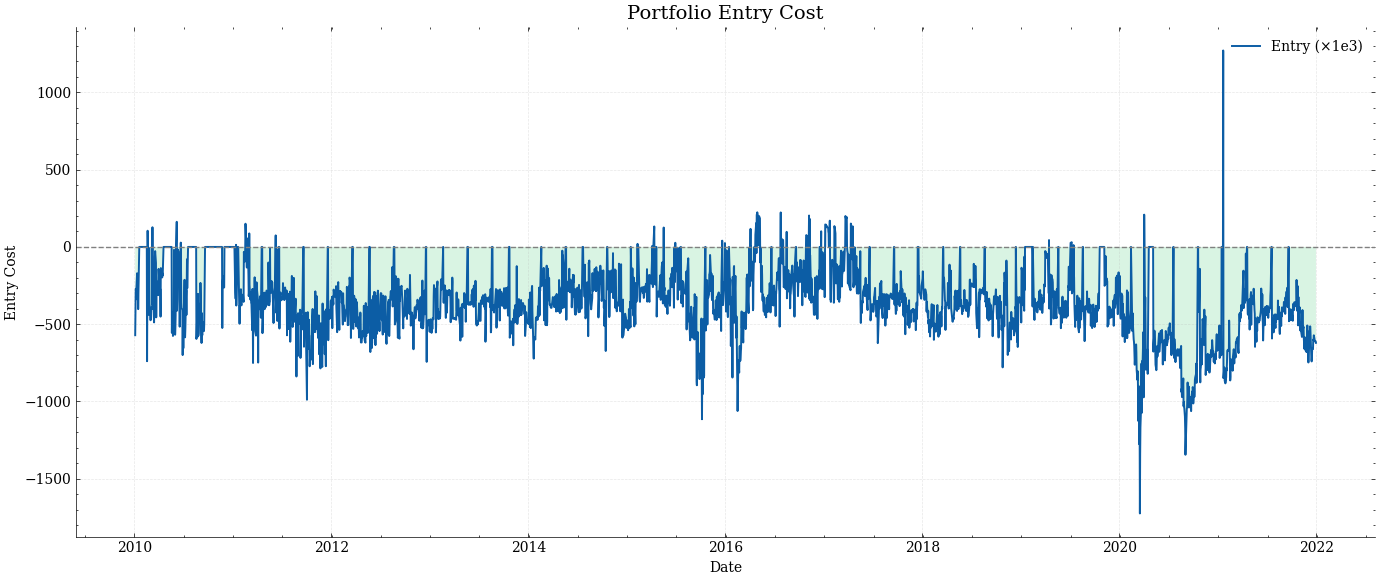

In [12]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(entry_cost.index, entry_cost, linewidth=1.4, label='Entry (×1e3)')
ax.fill_between(delta.index, 0, entry_cost, where=entry_cost >= 0, alpha=0.15)
ax.fill_between(delta.index, 0, entry_cost, where=entry_cost < 0, alpha=0.15)
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.set_title('Portfolio Entry Cost', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Entry Cost')
ax.grid(True, linestyle='--', alpha=0.3)
ax.spines[['top', 'right']].set_visible(False)
ax.legend(frameon=False, loc='upper right')
fig.tight_layout()

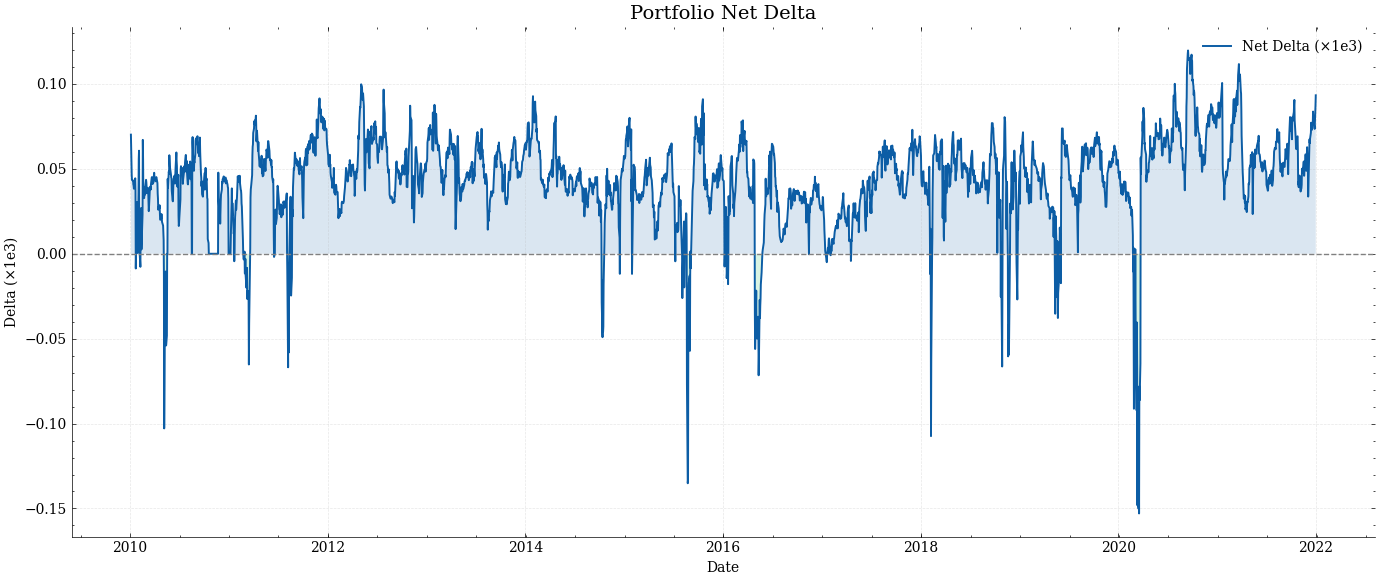

In [13]:
fig, ax = plt.subplots(figsize=(14, 6))
delta_scaled = delta 
ax.plot(delta.index, delta_scaled, linewidth=1.4, label='Net Delta (×1e3)')
ax.fill_between(delta.index, 0, delta_scaled, where=delta_scaled >= 0, alpha=0.15)
ax.fill_between(delta.index, 0, delta_scaled, where=delta_scaled < 0,  alpha=0.15)
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.set_title('Portfolio Net Delta', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Delta (×1e3)')
ax.grid(True, linestyle='--', alpha=0.3)
ax.spines[['top', 'right']].set_visible(False)
ax.legend(frameon=False, loc='upper right')
fig.tight_layout()

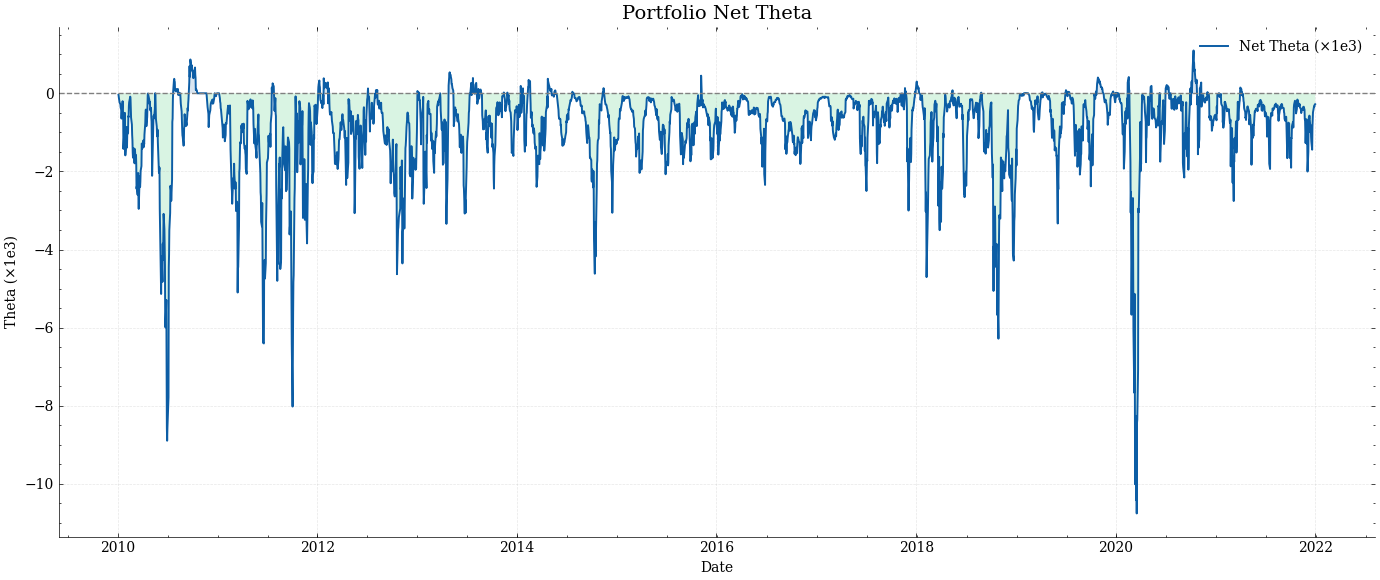

In [14]:
fig, ax = plt.subplots(figsize=(14, 6))
theta = theta / 1e3
ax.plot(theta.index, theta,  linewidth=1.4, label='Net Theta (×1e3)')
ax.fill_between(theta.index, 0, theta, where=theta >= 0, alpha=0.15)
ax.fill_between(theta.index, 0, theta, where=theta < 0, alpha=0.15)
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.set_title('Portfolio Net Theta', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Theta (×1e3)')
ax.grid(True, linestyle='--', alpha=0.3)
ax.spines[['top', 'right']].set_visible(False)
ax.legend(frameon=False, loc='upper right')
fig.tight_layout()

C:\Users\cameronA\AppData\Local\Temp\ipykernel_19708\2689078415.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  vix = yf.download("^VIX", start=allocation.index.min(), end=allocation.index.max())
[*********************100%***********************]  1 of 1 completed


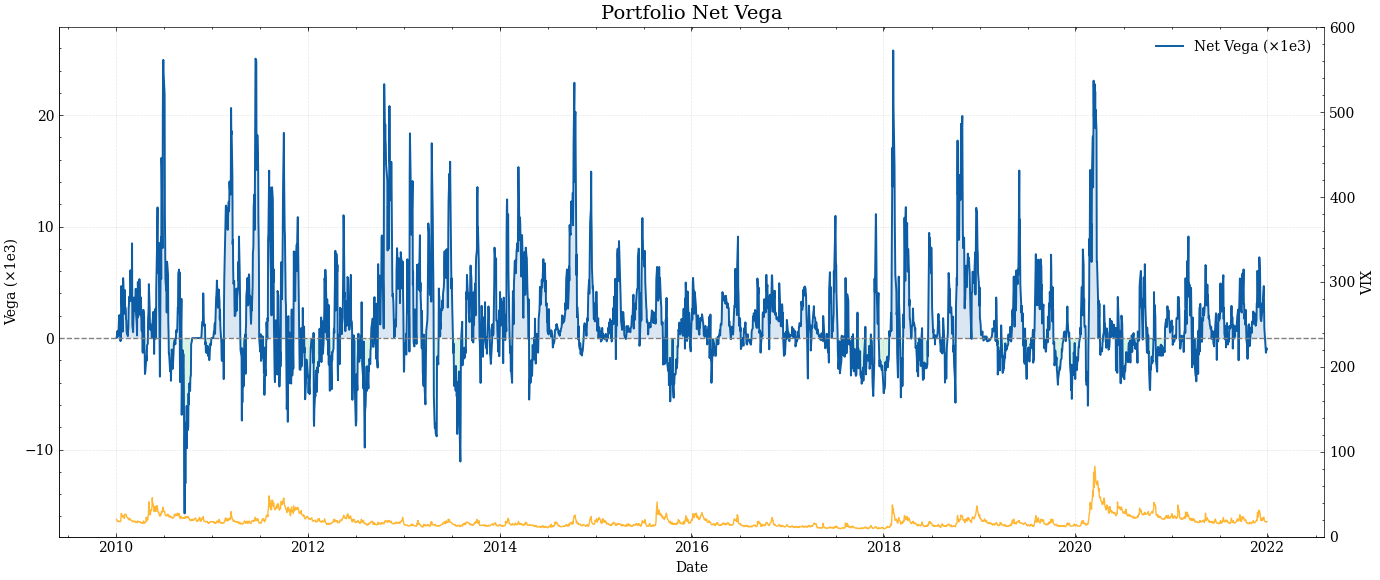

In [15]:

import yfinance as yf

# Get VIX and align to allocation dates
start= theta.index.min()
end = theta.index.max()
before = data_manager.combined_outputs
allocation = before['multi_stock']['allocation_underlying_value'].dropna()[start:end]
vix = yf.download("^VIX", start=allocation.index.min(), end=allocation.index.max())
vix = vix['Close'].reindex(allocation.index).ffill()

fig, ax = plt.subplots(figsize=(14, 6))
vega_scaled = vega / 1e3
ax.plot(vega.index, vega_scaled,  linewidth=1.4, label='Net Vega (×1e3)')
ax.fill_between(vega.index, 0, vega_scaled, where=vega_scaled >= 0, alpha=0.15)
ax.fill_between(vega.index, 0, vega_scaled, where=vega_scaled < 0, alpha=0.15)
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.set_title('Portfolio Net Vega', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Vega (×1e3)')
ax.grid(True, linestyle='--', alpha=0.3)
ax.spines[['top', 'right']].set_visible(False)
ax.legend(frameon=False, loc='upper right')


ax2 = ax.twinx()
ax2.plot(vix.index, vix, linewidth=1, alpha=0.8, color='orange', label='VIX Level')
ax2.set_ylabel('VIX')
ax2.set_ylim(0, 600)
#ax.axvline(pd.Timestamp("2020-02-15"), color='gray', linestyle='--', linewidth=2, label='Covid')
fig.tight_layout()


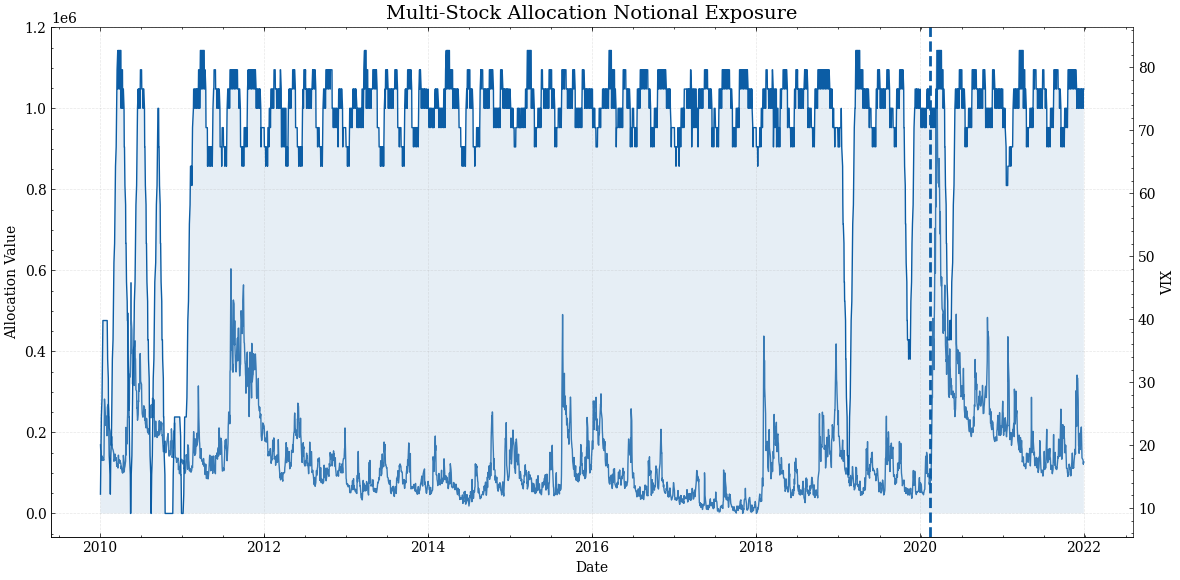

In [16]:

fig, ax = plt.subplots(figsize=(12, 6))

# Left y-axis: allocation
ax.plot(allocation.index, allocation, linewidth=1)
ax.fill_between(allocation.index, allocation,  alpha=0.1)

ax.set_title('Multi-Stock Allocation Notional Exposure', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Allocation Value')
ax.grid(True, linestyle='--', alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Right y-axis: VIX
ax2 = ax.twinx()
ax2.plot(vix.index, vix, linewidth=1, alpha=0.8)
ax2.set_ylabel('VIX')
ax.axvline(pd.Timestamp("2020-02-15"), linestyle='--', linewidth=2, label='Covid')
fig.tight_layout()


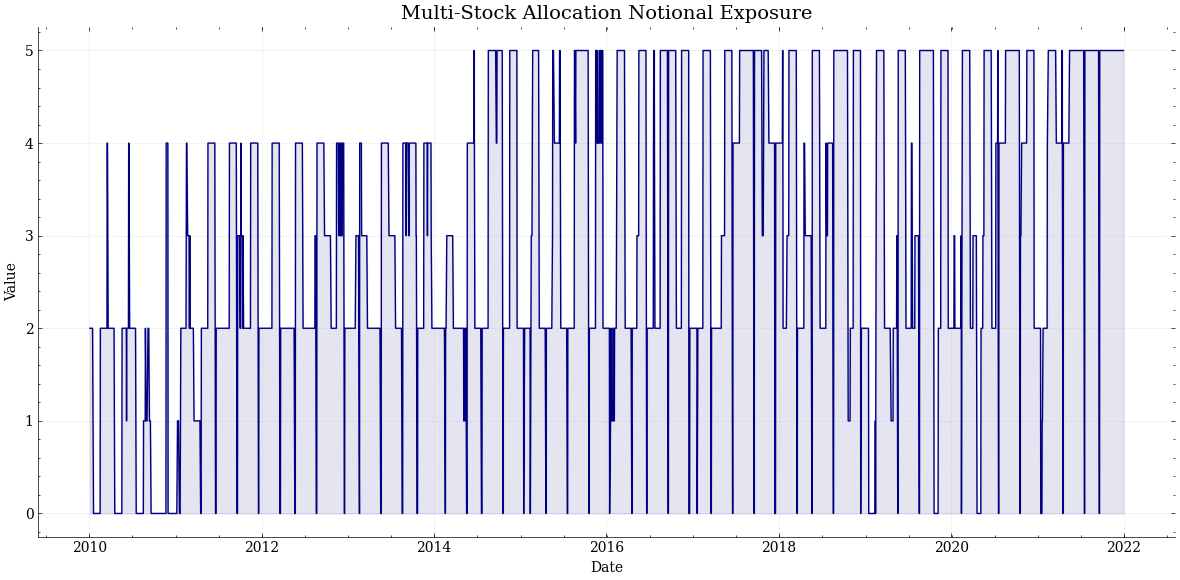

In [17]:
before = data_manager.combined_outputs
allocation = before['multi_stock']['stocks_entered'].dropna()[start:end]

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(allocation.index, allocation, color='navy', linewidth=1)
ax.fill_between(allocation.index, allocation, color='navy', alpha=0.1)
ax.set_title('Multi-Stock Allocation Notional Exposure', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.grid(True, linestyle='--', alpha=0.3)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()